In [8]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Libraries and Load Data

In [26]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE


# Load the dataset
file_path = '/content/drive/MyDrive/DataMining/BankMarketing-main/bank_dataset_cleaned.csv'
data = pd.read_csv(file_path)

# Define target variable and features
target_column = 'y'
X = data.drop(columns=[target_column])
y = data[target_column]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Clustering Analysis

## K-Means with Elbow Method

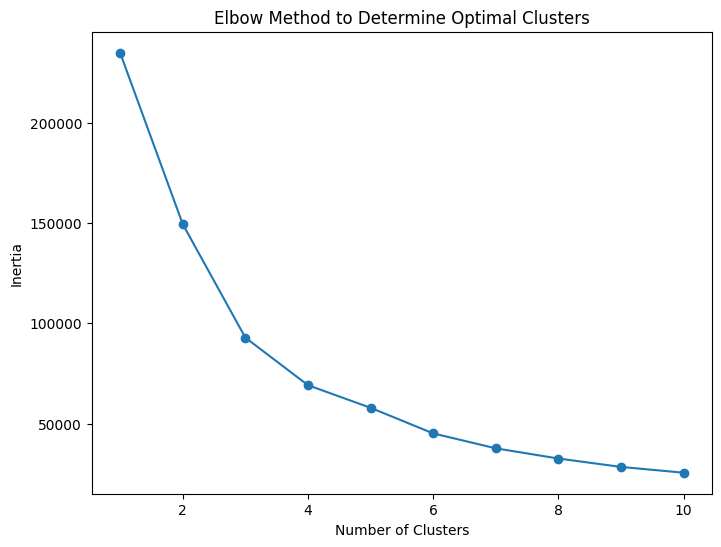

In [10]:
# PCA to reduce dimensionality for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Elbow Method to determine optimal number of clusters
inertia = []
range_clusters = range(1, 11)

for k in range_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

# Plot Elbow Method
plt.figure(figsize=(8, 6))
plt.plot(range_clusters, inertia, marker='o')
plt.title("Elbow Method to Determine Optimal Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()


## Evaluate and Visualize K-Means

K-Means Silhouette Score (PCA-reduced): 0.38


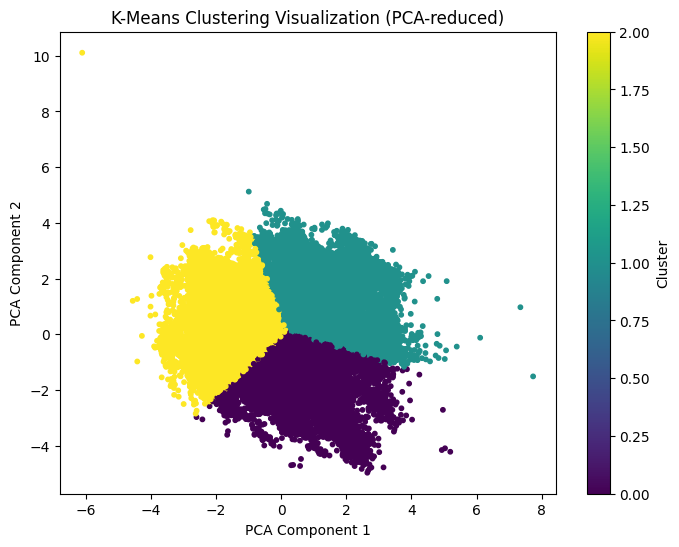

In [11]:
# Apply K-Means with 3 clusters (based on Elbow Method)
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(X_pca)

# Evaluate K-Means with Silhouette Score
kmeans_silhouette = silhouette_score(X_pca, kmeans_labels)
print(f"K-Means Silhouette Score (PCA-reduced): {kmeans_silhouette:.2f}")

# Visualize K-Means Clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', s=10)
plt.title("K-Means Clustering Visualization (PCA-reduced)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster")
plt.show()


## DBSCAN Clustering

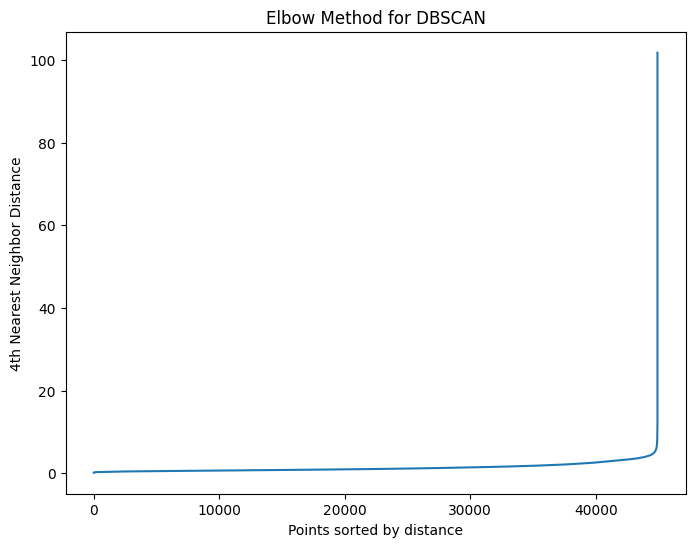

In [12]:
from sklearn.neighbors import NearestNeighbors


neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)
distances = np.sort(distances[:, 4], axis=0)

# Plot distances to find the elbow
plt.figure(figsize=(8, 6))
plt.plot(distances)
plt.title("Elbow Method for DBSCAN")
plt.xlabel("Points sorted by distance")
plt.ylabel("4th Nearest Neighbor Distance")
plt.show()


DBSCAN Silhouette Score: -0.43


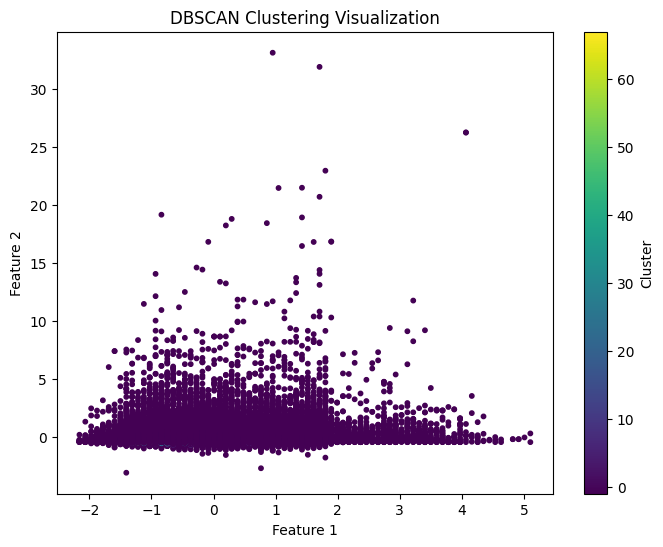

In [13]:
# Apply DBSCAN with tuned parameters
dbscan = DBSCAN(eps=0.5, min_samples=10)
dbscan_labels = dbscan.fit_predict(X_scaled)

# Evaluate DBSCAN with Silhouette Score
if len(set(dbscan_labels)) > 1:
    dbscan_silhouette = silhouette_score(X_scaled, dbscan_labels)
    print(f"DBSCAN Silhouette Score: {dbscan_silhouette:.2f}")
else:
    print("DBSCAN resulted in a single cluster; Silhouette Score cannot be calculated.")

# Visualize DBSCAN Clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=dbscan_labels, cmap='viridis', s=10)
plt.title("DBSCAN Clustering Visualization")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar(label="Cluster")
plt.show()


## Clustring with Gaussian Mixture Model

Gaussian Mixture Model Silhouette Score: 0.10


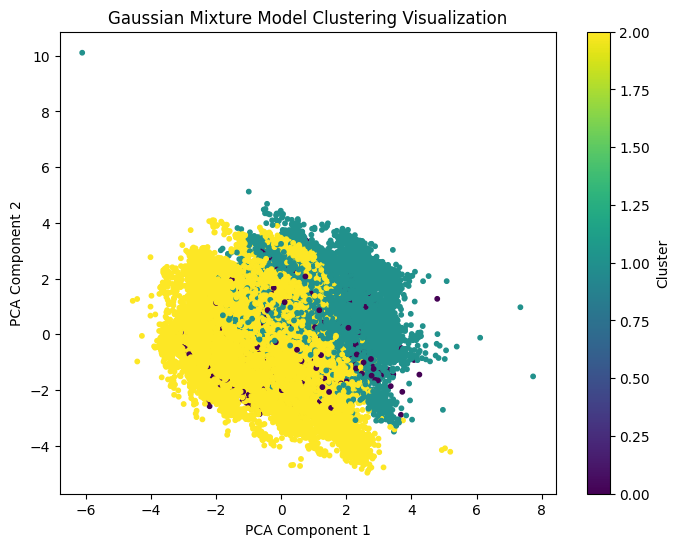

In [14]:
# Apply GMM with 3 components
gmm = GaussianMixture(n_components=3, random_state=42)
gmm_labels = gmm.fit_predict(X_scaled)

# Evaluate GMM with Silhouette Score
gmm_silhouette = silhouette_score(X_scaled, gmm_labels)
print(f"Gaussian Mixture Model Silhouette Score: {gmm_silhouette:.2f}")

# Visualize GMM Clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=gmm_labels, cmap='viridis', s=10)
plt.title("Gaussian Mixture Model Clustering Visualization")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster")
plt.show()


# Classification Analysis

## Handle Class Imbalance

In [27]:
# Apply SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Check class distribution
print("Class distribution after SMOTE:")
print(pd.Series(y_resampled).value_counts())


Class distribution after SMOTE:
y
0    39668
1    39668
Name: count, dtype: int64


## Train-Test Split

In [28]:
# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)


## Train and Evaluate Multiple Classifiers


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94     11901
           1       0.92      0.97      0.95     11900

    accuracy                           0.94     23801
   macro avg       0.94      0.94      0.94     23801
weighted avg       0.94      0.94      0.94     23801



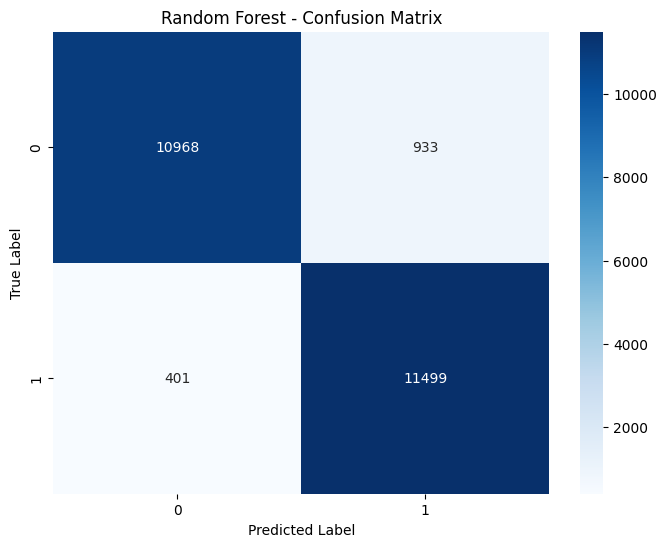


Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.92     11901
           1       0.91      0.93      0.92     11900

    accuracy                           0.92     23801
   macro avg       0.92      0.92      0.92     23801
weighted avg       0.92      0.92      0.92     23801



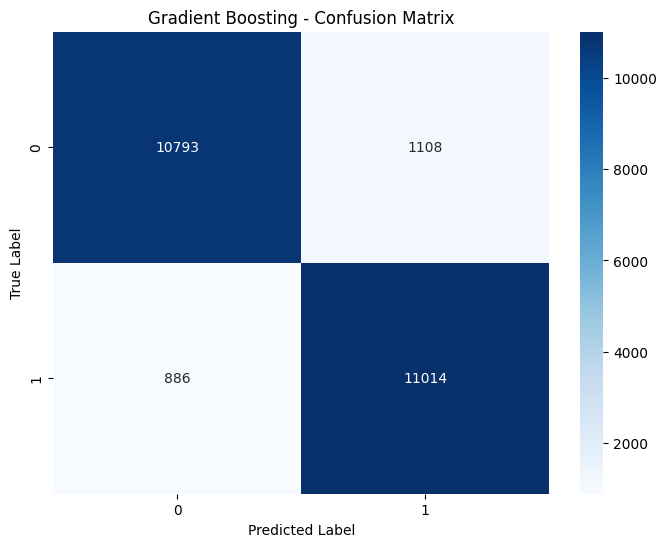

In [29]:
# Initialize classifiers
classifiers = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

# Train and evaluate each classifier
results = {}
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Evaluate classifier
    report = classification_report(y_test, y_pred, output_dict=True)
    results[name] = report["accuracy"]

    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()


## Compare Classifier Performance

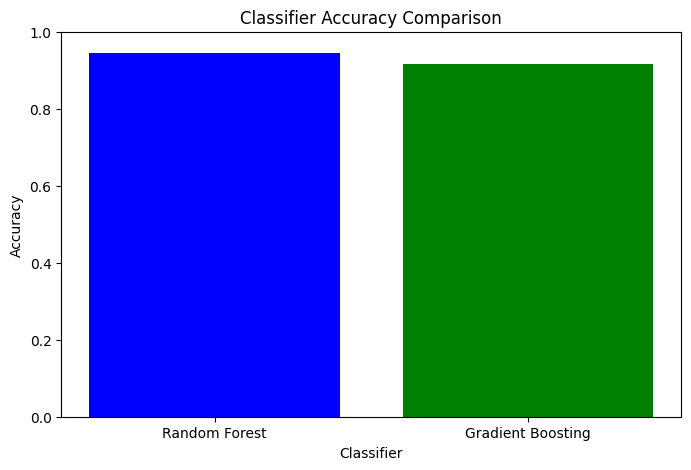

In [30]:
# Plot classifier accuracy comparison
plt.figure(figsize=(8, 5))
plt.bar(results.keys(), results.values(), color=['blue', 'green'])
plt.title("Classifier Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xlabel("Classifier")
plt.ylim(0, 1)
plt.show()
